In [777]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [778]:
# Загрузка данных: датасет MovieLens
url = 'https://files.grouplens.org/datasets/movielens/ml-100k/u.data'
columns = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv(url, sep='\t', names=columns)
df = df.drop('timestamp', axis=1) # Удаление ненужного столбца; остаются пользователь, фильм и оценка

In [779]:
# Анализ данных

# Проверка пропусков
print("Проверка пропусков:")
print(df.isnull().sum())  # Количество пропусков в каждой колонке

# Выявление аномальных значений
print("\nПроверка аномалий:")
print(df[(df['rating'] < 1) | (df['rating'] > 5)])

# Пропуски и аномалии не обнаружены

Проверка пропусков:
user_id    0
item_id    0
rating     0
dtype: int64

Проверка аномалий:
Empty DataFrame
Columns: [user_id, item_id, rating]
Index: []


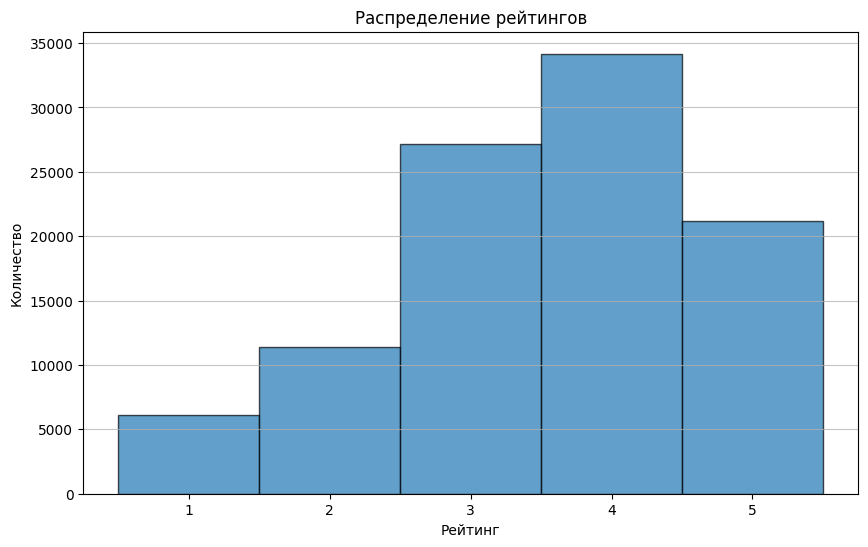

Средний рейтинг: 3.53
Медианный рейтинг: 4.00
Стандартное отклонение: 1.13


In [780]:
# Анализ распределения данных

# Построение гистограммы
plt.figure(figsize=(10, 6))
plt.hist(df['rating'], bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], edgecolor='black', alpha=0.7)
plt.title('Распределение рейтингов')
plt.xlabel('Рейтинг')
plt.ylabel('Количество')
plt.xticks(range(1, 6))
plt.grid(axis='y', alpha=0.75)
plt.show()

# Расчет статистик
mean_rating = df['rating'].mean()
median_rating = df['rating'].median()
std_rating = df['rating'].std()

print(f'Средний рейтинг: {mean_rating:.2f}')
print(f'Медианный рейтинг: {median_rating:.2f}')
print(f'Стандартное отклонение: {std_rating:.2f}')

# Отсюда можно сделать вывод, что бОльшая часть пользователей ставит высокие оценки, однако
# Большое стандартное отклонение указывает на разнообразие в оценках и наличие фильмов с очень низким рейтингом
# Или пользователей, часто ставящих низкие оценки

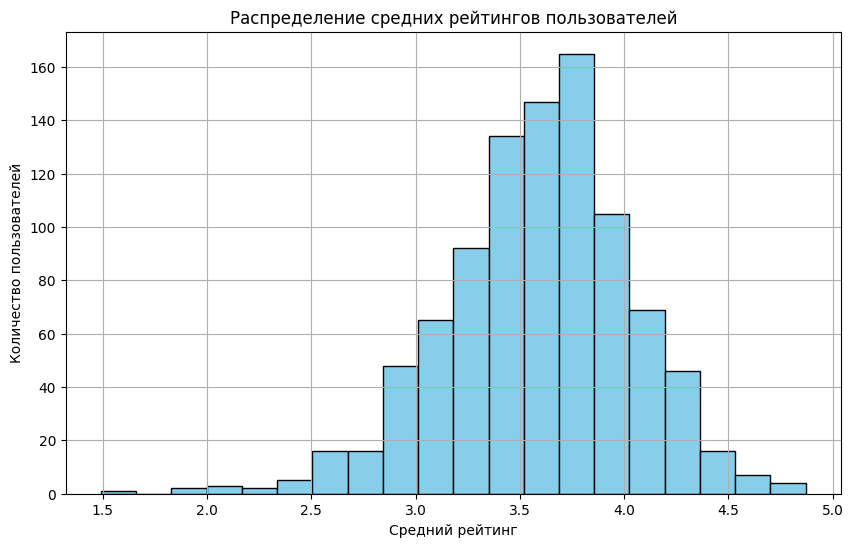

Статистика средних рейтингов пользователей:
count    943.000000
mean       3.588191
std        0.445233
min        1.491954
25%        3.323054
50%        3.620690
75%        3.869565
max        4.869565
Name: rating, dtype: float64


In [781]:
# Расчет среднего рейтинга для каждого пользователя
user_mean_ratings = df.groupby('user_id')['rating'].mean()

# Визуализация распределения средних рейтингов пользователей с помощью matplotlib
plt.figure(figsize=(10, 6))
plt.hist(user_mean_ratings, bins=20, color='skyblue', edgecolor='black')
plt.title('Распределение средних рейтингов пользователей')
plt.xlabel('Средний рейтинг')
plt.ylabel('Количество пользователей')
plt.grid(True)
plt.show()

# Основные статистики
print("Статистика средних рейтингов пользователей:")
print(user_mean_ratings.describe())

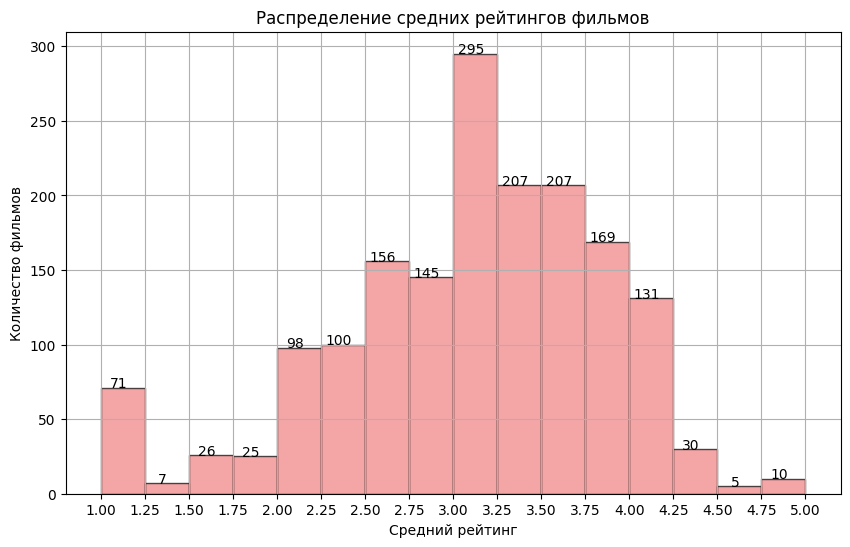


Распределение количества фильмов по рейтингам:
       Диапазон  Число фильмов
0   1.00 - 1.25             71
1   1.25 - 1.50              7
2   1.50 - 1.75             26
3   1.75 - 2.00             25
4   2.00 - 2.25             98
5   2.25 - 2.50            100
6   2.50 - 2.75            156
7   2.75 - 3.00            145
8   3.00 - 3.25            295
9   3.25 - 3.50            207
10  3.50 - 3.75            207
11  3.75 - 4.00            169
12  4.00 - 4.25            131
13  4.25 - 4.50             30
14  4.50 - 4.75              5
15  4.75 - 5.00             10
Статистика средних рейтингов фильмов:
count    1682.000000
mean        3.076045
std         0.781662
min         1.000000
25%         2.659600
50%         3.161528
75%         3.653428
max         5.000000
Name: rating, dtype: float64


In [782]:
# Расчет среднего рейтинга для каждого фильма
movie_mean_ratings = df.groupby('item_id')['rating'].mean()

# Границы для средних рейтингов с шагом 0.25
bins = np.arange(1.0, 5.25, 0.25)  # от 1.0 до 5.0 с шагом 0.25

# Подсчет количества фильмов в каждом диапазоне среднего рейтинга
rating_counts = np.histogram(movie_mean_ratings, bins=bins)[0]

# Визуализация распределения средних рейтингов фильмов
plt.figure(figsize=(10, 6))
plt.hist(movie_mean_ratings, bins=bins, color='lightcoral', edgecolor='black', alpha=0.7)
plt.title('Распределение средних рейтингов фильмов')
plt.xlabel('Средний рейтинг')
plt.ylabel('Количество фильмов')
plt.xticks(bins)
plt.grid(True)

for i in range(len(rating_counts)):
    plt.text(bins[i] + 0.1, rating_counts[i], str(rating_counts[i]), fontsize=10, ha='center')
plt.show()

# Текстовый вывод
rating_distribution = pd.DataFrame({
    'Диапазон': [f"{bins[i]:.2f} - {bins[i + 1]:.2f}" for i in range(len(rating_counts))],
    'Число фильмов': rating_counts
})
print("\nРаспределение количества фильмов по рейтингам:")
print(rating_distribution)

# Основные статистики
print("Статистика средних рейтингов фильмов:")
print(movie_mean_ratings.describe())

# Таким образом, именно среди фильмов, а не среди пользователей, попадаются представители с частыми плохими оценками
# Если модель будет на них слишком детально обучаться, она будет акцентироваться на латентных признаках,
# Связанных с плохими фильмами, что требует корректировки
# Фильмов с рейтингом ниже 2.5 - почти 20%
# Решение: применить к плохим фильмам веса при обучении VAE

Корреляция между средним рейтингом и количеством оценок: 0.4296591698676232


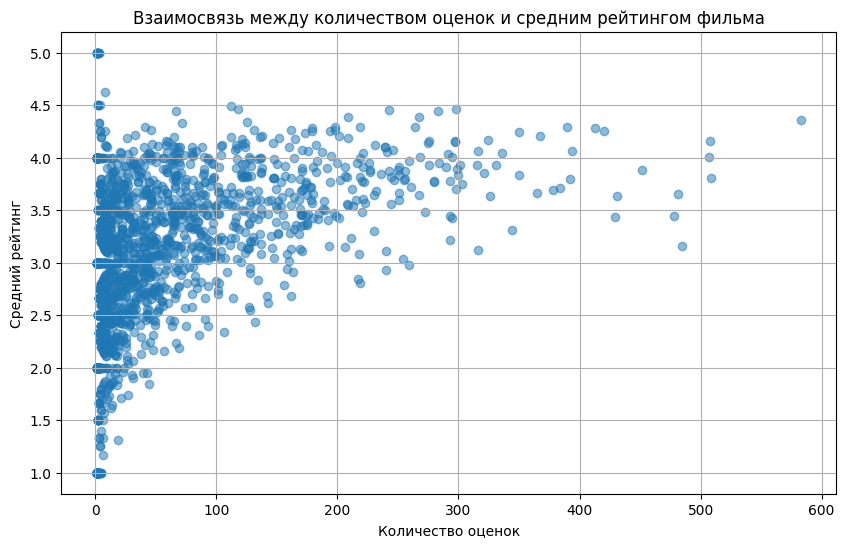

In [783]:
# Оценим взаимосвязь между рейтингом фильма и количеством оценок

# Рассчитываем средний рейтинг и количество оценок для каждого фильма
item_stats = df.groupby('item_id')['rating'].agg(['mean', 'count']).reset_index()
item_stats.columns = ['item_id', 'mean_rating', 'rating_count']

# Вычисляем корреляцию
correlation = item_stats['mean_rating'].corr(item_stats['rating_count'])
print(f'Корреляция между средним рейтингом и количеством оценок: {correlation}')

# Визуализация взаимосвязи
plt.figure(figsize=(10, 6))
plt.scatter(item_stats['rating_count'], item_stats['mean_rating'], alpha=0.5)
plt.title('Взаимосвязь между количеством оценок и средним рейтингом фильма')
plt.xlabel('Количество оценок')
plt.ylabel('Средний рейтинг')
plt.grid(True)
plt.show()

# Взаимосвязь есть, но не слишком сильная
# Однако у фильмов с очень низким рейтингом в своей массе мало оценок
# Это проблема, поскольку модель будет предсказывать низкий рейтинг таких фильмов для большинства пользователей,
# Что приведет к искажению истинного качества фильма
# При этом у них сохраняется проблема плохих фильмов
# Таким образом, стоит применить еще больший вес для плохих фильмов с низким рейтингом

# Мало количество отзывов характерно и для фильмов с очень хорошим рейтингом
# Это тоже проблема, т.к. небольшое число отзывов может исказить реальную картину о качестве фильма
# Применим веса - но не такие большие, как для плохих фильмов


Количество пользователей, оценивших каждый фильм:
count    1682.000000
mean       59.453032
std        80.383846
min         1.000000
25%         6.000000
50%        27.000000
75%        80.000000
max       583.000000
Name: user_id, dtype: float64


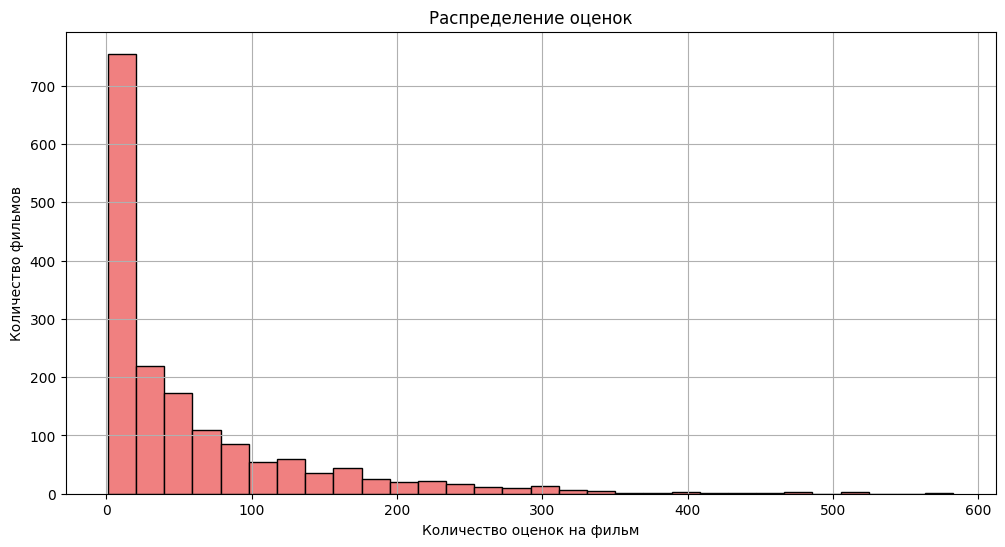

In [784]:
# Количество пользователей, оценивших каждый фильм
item_ratings_count = df.groupby('item_id')['user_id'].count()

# Вывод статистики
print("\nКоличество пользователей, оценивших каждый фильм:")
print(item_ratings_count.describe())

# Визуализация распределения количества оценок для фильмов
plt.figure(figsize=(12, 6))
plt.hist(item_ratings_count, bins=30, color='lightcoral', edgecolor='black')
plt.title('Распределение оценок')
plt.xlabel('Количество оценок на фильм')
plt.ylabel('Количество фильмов')
plt.grid(True)
plt.show()

In [785]:
# Z-нормализация рейтингов: без нормализации латентное пространство может быть неинтерпретируемым,
# Так как различия в масштабах могут затруднить понимание, какие скрытые факторы влияют на рекомендации;
# Одни пользователи в своей системе оценивания могут ставит от 3 до 5, другие от 1 до 4,
# Нормализация нивелирует эти различия
# Z-нормализация - наиболее предпочтительный вид нормализации для нейронных сетей, подобных VAE

mean_rating = df['rating'].mean()
std_rating = df['rating'].std()

def z_normalization(ratings):
    normalized_ratings = (ratings - mean_rating) / std_rating
    return normalized_ratings

def inverse_z_normalization(normalized_ratings): # Восстанавливает исходные значения
    original_ratings = normalized_ratings * std_rating + mean_rating
    return original_ratings

df['normalized_rating_z'] = z_normalization(df['rating'])

In [786]:
batch_size = 64

# Получение уникальных пользователей и фильмов
n_users = df.user_id.nunique()
n_items = df.item_id.nunique()

quantity = [] # Хранит число оценок каждого фильма
for item in range(0, n_items):
    quantity.append((df['item_id'] == item + 1).sum())
    
quantity_1d = torch.tensor(quantity).to(device) # Превратить в тензор; перемещение тензора на выбранное устройство (GPU или CPU)
quantity_2d = quantity_1d.unsqueeze(0).repeat(batch_size, 1) # Повторить построчно согласно размеру батча для удобства обработки

In [787]:
# Генерация матрицы взаимодействий (users x items)
interaction_matrix = np.zeros((n_users, n_items))
for row in df.itertuples():
    interaction_matrix[row.user_id - 1, row.item_id - 1] = row.normalized_rating_z
    
# Разделение на тренировочную и тестовую выборки
train_data, test_data = train_test_split(interaction_matrix, test_size=0.2, random_state=42)

#Преобразование в тензор
train_data = torch.FloatTensor(train_data).to(device)
test_data = torch.FloatTensor(test_data).to(device)

In [805]:
class VAE(nn.Module):
    def __init__(self, n_items, hidden_dim=128, hidden_dim2 = 64, latent_dim=32):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(n_items, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, latent_dim * 2)  # Два, потому что для двух параметров распределения
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, n_items),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, log_var): # Mu - среднее значение, log_var - логарифм дисперсии
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std # Возвращает случайное значение, соответствующее распределению

    def forward(self, x):
        # Кодирование
        h = self.encoder(x)
        mu, log_var = torch.chunk(h, 2, dim=1) # Разделение тензора из энкодера на две части (для двух параметров)
        
        # Репараметризация
        z = self.reparameterize(mu, log_var) # Набор случайных значений, соотвествующих распределению
        
        # Декодирование
        return self.decoder(z), mu, log_var

In [806]:
def weight_function(x):
    if x.size(0) != batch_size: # Подгоняем размер quantity-тензора под тензор x
        quantity_temp = quantity_1d.unsqueeze(0).repeat(x.size(0), 1)
    else:
        quantity_temp = quantity_2d
    
    rare_cond = quantity_temp < 27 # Условие для фильмов с малым количеством просмотров...
    bad_cond = inverse_z_normalization(x) < 2.5 # ...И определенными рейтингами
    good_cond = inverse_z_normalization(x) > 4
    
    return torch.where(bad_cond & rare_cond, torch.tensor(0.5), # Веса в зависимости от количества просмотров и рейтинга
                     torch.where(good_cond & rare_cond, torch.tensor(0.9), 
                                  torch.where(bad_cond, torch.tensor(0.8), torch.tensor(1))))

In [807]:
def loss_function(recon_x, x, mu, log_var, weight_function): # Функция потерь включает в себя сумму двух параметров
    # Реконструкционная ошибка - параметр, оценивающий, насколько реконструкция близка к оригиналу
    loss_function = nn.MSELoss(reduction='none')  # Убираем редукцию, чтобы получить элементные потери
    recon_loss = loss_function(recon_x, x)
    
    # Создаем тензор весов
    weights = weight_function(x)
    
    # Применяем веса 
    weighted_loss = recon_loss * weights
    # Усредняем потери по всем элементам
    final_loss = weighted_loss.mean()
    
    # KL-дивергенция - параметр, оценивающий, насколько распределение близко к нормальному
    kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    
    return final_loss + kl_div

In [808]:
def loss_test(recon_x, x, mu, log_var): # Ошибка при тестировании (веса уже не учитываются)
    recon_loss = nn.MSELoss()(recon_x, x)
    kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    
    return recon_loss + kl_div

In [809]:
def train(model, train_data, epochs=20, batch_size=64, lr=0.005):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train() # Режим обучения
    
    for epoch in range(epochs):
        # Перемешиваем содержимое батчей на каждой эпохе
        shuffled_indices = np.random.permutation(len(train_data))
        train_data_shuffled = train_data[shuffled_indices]
        train_loss = 0
        batches = 0
        for i in range(0, len(train_data), batch_size):
            batches += 1
            batch = train_data_shuffled[i:i + batch_size]
            optimizer.zero_grad() # Обнуление градиентов параметров модели на каждом шаге
            recon_batch, mu, log_var = model(batch)
            loss = loss_function(recon_batch, batch, mu, log_var, weight_function) # Получение реконструкции и вычисление ошибки
            loss.backward() # Шаг обратного распространения, который вычисляет градиенты для всех параметров модели
            train_loss += loss.item()
            optimizer.step() # Оптимизатор обновляет параметры модели на основе вычисленных градиентов
        
        print(f'Epoch {epoch+1}, Loss: {train_loss / batches}')

In [810]:
def test(model, test_data):
    model.eval() # Режим тестирования
    with torch.no_grad(): # Отключение вычисления градиентов при тестировании для экономии ресурсов
        test_loss = 0
        batches = 0
        for i in range(0, len(test_data), batch_size):
            batches += 1
            batch = test_data[i:i + batch_size]
            recon_batch, mu, log_var = model(batch)
            loss = loss_test(recon_batch, batch, mu, log_var)
            test_loss += loss.item()

    print(f'\nTest Loss: {test_loss / batches}')

In [817]:
def check(model):
    # Инициализация и обучение
    train(model, train_data, epochs=epochs, batch_size=batch_size)

    # Тестирование
    test(model, test_data)

In [828]:
epochs = 20
model = VAE(n_items).to(device)
check(model)

Epoch 1, Loss: 2.2086813946564994
Epoch 2, Loss: 0.48053551216920215
Epoch 3, Loss: 0.17450678472717604
Epoch 4, Loss: 0.10096926614642143
Epoch 5, Loss: 0.0778607955823342
Epoch 6, Loss: 0.06706547923386097
Epoch 7, Loss: 0.061757564855118595
Epoch 8, Loss: 0.05911706822613875
Epoch 9, Loss: 0.05799248442053795
Epoch 10, Loss: 0.0571322695662578
Epoch 11, Loss: 0.05599464848637581
Epoch 12, Loss: 0.0557828430707256
Epoch 13, Loss: 0.05522927859177192
Epoch 14, Loss: 0.05512425055106481
Epoch 15, Loss: 0.054732397509117924
Epoch 16, Loss: 0.05486341969420513
Epoch 17, Loss: 0.05435950836787621
Epoch 18, Loss: 0.05435496879120668
Epoch 19, Loss: 0.05417172145098448
Epoch 20, Loss: 0.05433553953965505

Test Loss: 0.0671204390625159


In [825]:
def recommend(model, user_id, top_k=10): # Рекомендации для конкретного пользователя
    model.eval()
    user_ratings = train_data[user_id - 1].unsqueeze(0) 
    with torch.no_grad():
        recon_ratings, _, _ = model(user_ratings)
    
    # Сортировка рекомендаций
    recon_ratings = recon_ratings.cpu().numpy().flatten()
    recommended_items = np.argsort(recon_ratings)[::-1]
    
    # Возвращение топа-K фильмов
    return recommended_items[:top_k]

# Пример для пользователя с ID 1
print(recommend(model, 1, top_k=10))

[ 49  99 312  97 171 180 126 317  63 190]
